# **Meerkat Call Classifier**

This code takes in examples of calls of different types, trains a conv net model to detect which type, then can run this on new data.

In [15]:
from meerkat_call_detector_library import *
import os
import re

#params
train_classif_model = False
test_classif_model = False
batch_size=10
clips_dir  = '/home/arianasp/meerkat_detector/clips'
call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth']
verbose = True
model_dir = '/home/arianasp/meerkat_detector/models'
classif_model_name = 'classifier_7types_20epochs.h5'
epochs = 20
steps_per_epoch = 10000
max_size = 512

#test files
test_wav = '/home/arianasp/meerkat_detector/data/full_recordings/HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.wav'
test_csv = '/home/arianasp/meerkat_detector/ground_truth/HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.csv'

ground_truth_dir = '/home/arianasp/meerkat_detector/ground_truth'
wav_dir = '/home/arianasp/meerkat_detector/data/full_recordings'
files = os.listdir(ground_truth_dir)
test_csvs = [file for file in files if not(re.search('_label.csv',file) or re.search('_label.CSV',file))]
wav_files = os.listdir(wav_dir)
wav_base = 

#PARAMS (don't change probably)
pad_len = 127
samprate = 8000
win_len = 4096

#MAIN

#----------TRAIN OR LOAD MODEL -----------------------
if(train_classif_model):
    
    model = classifier_model(n_classes=10)


    # use categorical_crossentropy loss if your training data are one-hot encoded vectors
    # and use sparse_categorical_crossentropy loss if your training data
    # are integers indicating the class label (Keras one-hot encodes this internally for training)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['sparse_categorical_accuracy']) # same applies for sparse_categorical_accuracy



        
    #fit model
    model.fit_generator(data_generator_for_classif(clips_dir = clips_dir,batch_size = batch_size), epochs=epochs, use_multiprocessing=True, workers=16, steps_per_epoch=steps_per_epoch)

    #Save fitted model
    print('Saving model as: ' + classif_model_name)
    model.save(filepath=model_dir + '/' + classif_model_name) 

else:
    model = load_model(model_dir + '/' + classif_model_name)
    
# ------------- TEST MODEL -----------------------------

if(test_classif_model):
    labels = read_labels_for_classif(test_csv)

    X, y = generate_test_data_for_classif(labels,test_wav)

    confusion = evaluate_classif(model,X,y,call_types)

    plot_confusion_matrix(confusion,call_types)

['HM_HRT_R09_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221110_LABEL_RY.csv', 'HM_RT_R10_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221102_SS.csv', 'HM_HTB_R14_file_4_(2017_08_23-06_44_59)_ASWMUX221052._labelSS.csv', 'HM_HRT_R07_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221092_LABEL_RY.csv', 'HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.csv', 'HM_VLF206_SOUNDFOC_20170905_1_labelSS.csv', 'HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102_labelSS.csv', 'HM_VLF206_SOUNDFOC_20170823_2_LABEL_RY.csv', 'HM_LT_R07_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221092_LABEL_RY.csv', 'HM_LT_R07_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221092_SS.csv', 'HM_VLF206_SOUNDFOC_20170824_1_labelSS.csv', 'HM_RT_R12_file_5_(2017_08_24-06_44_59)_ASWMUX221102_LABEL_RY.csv', 'HM_VLF206_SOUNDFOC_20170823_1_LABEL_RY.csv', 'HM_LT_R09_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221110_LABEL_RY.csv', 'HM_VLF206_SOUNDFOC_20170905_2_labelSS.csv', 'HM_VHMM002_HRT_A

/home/arianasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


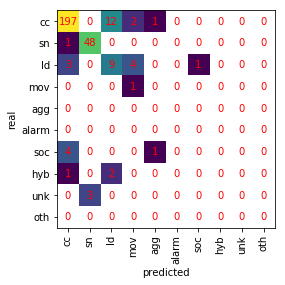

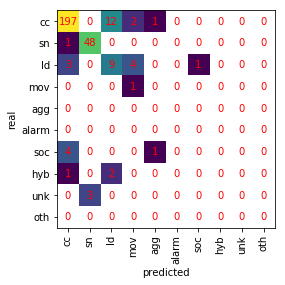

In [9]:
def plot_confusion_matrix(confusion,call_types,logscale=True):
    fig = plt.figure()
    plt.xticks(np.arange(start=0,stop=len(call_types)),call_types,rotation='vertical')
    plt.yticks(np.arange(start=0,stop=len(call_types)),call_types)
    plt.ylabel('real')
    plt.xlabel('predicted')
    if(logscale):
        plt.imshow(np.log(confusion))
    else:
        plt.imshow(confusion)
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            plt.annotate(text = str(int(confusion[i,j])), xy=(j, i), ha='center',va='center',color='red')
    return(fig)

plot_confusion_matrix(confusion,call_types)